# Noise propagation in a chain of N-qubit - Qutip implementation

In [170]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import itertools
from basic_units import radians, degrees, cos
import os 
import csv 
import pandas as pd 

col = ['C0','C1','C2','C3']

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [r'\boldmath',r'\usepackage{physics}', r'\usepackage{slashed}']
 

/Users/alicepagano/anaconda3/envs/qi/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  from ipykernel import kernelapp as app


## Perfect blockade regime

### Functions definition

In [3]:
# Function for computing phase 
def phase_func(z):
    # a + ib
    a = np.real(z)
    b = np.imag(z)
    
    if b==0:
        ph = 2*np.pi
    if (a>=0 and b>0): # I
        ph = np.arctan(b/a) 
    if (a<0 and b>0): # II
        ph = np.arctan(b/a) + np.pi
    if (a<0 and b<0): # III
        ph = np.arctan(b/a) + np.pi
    if (a>0 and b<0): # IV
        ph = 2*np.pi + np.arctan(b/a)
        
    return ph

In [4]:
# Definition of the Hamiltonian for a two-qubit CZ gate
def hamiltonian(Omega,Delta):
    
    psi00 = tensor(basis(3,0),basis(3,0))
    psi01 = tensor(basis(3,1),basis(3,0)) 
    psi0r = tensor(basis(3,2),basis(3,0))
    psi10 = tensor(basis(3,0),basis(3,1))
    psi11 = tensor(basis(3,1),basis(3,1)) 
    psi1r = tensor(basis(3,2),basis(3,1))
    psir0 = tensor(basis(3,0),basis(3,2))
    psir1 = tensor(basis(3,1),basis(3,2))
    psirr = tensor(basis(3,2),basis(3,2))

    H0  = 0 * tensor(psi00.dag(),psi00)
    
    H01 = 1/2 * ( Omega * tensor(psi01.dag(),psi0r) + 
             np.conj(Omega) * tensor(psi0r.dag(),psi01) ) - Delta * tensor(psi0r.dag(),psi0r)
    
    H10 = 1/2 * ( Omega * tensor(psi10.dag(),psir0) + 
             np.conj(Omega) * tensor(psir0.dag(),psi10) ) - Delta * tensor(psir0.dag(),psir0)

    H2  = 1/2 * ( Omega * ( tensor(psi11.dag(),psir1) + tensor(psi11.dag(),psi1r) ) 
            + np.conj(Omega) * ( tensor(psir1.dag(),psi11) + tensor(psi1r.dag(),psi11) ) 
            ) - Delta/2 * ( tensor(psir1.dag(),psir1) + tensor(psir1.dag(),psi1r) 
                           + tensor(psi1r.dag(),psir1) + tensor(psi1r.dag(),psi1r))

    H = H0 + H01 + H10 + H2
    
    return H

# Optimal phase between two pulse
def exp_xi(Delta,Omega,tau):
    
    y = Delta/Omega
    s = Omega * tau
    
    a = np.sqrt(y**2+1)
    b = s*a/2
    
    return (a*np.cos(b) + 1j*y*np.sin(b)) / (-a*np.cos(b) + 1j*y*np.sin(b))

In [5]:
# Chain state initialization
def chain_init(N,state_first,state_last):
    
    psi = basis(3,state_first) 
    
    for i in range(N-2):
        psi = tensor(psi,basis(3,0))
        
    psi = tensor(psi,basis(3,state_last))
    
    return psi

In [6]:
# Chain CZ-gate function
def chain_CZ_gate(psi,Omega,Delta,tau,niter):
        
    N = len(dims(psi)[0]) # Number of qubits in the chain
    I = qeye(3) # Define identity matrix
    Hp1 = Qobj( hamiltonian(Omega,Delta), dims= [[3, 3, 3], [3, 3, 3]] ) # First pulse hamiltonian
    Hp2 =  Qobj( hamiltonian(Omega * exp_xi(Delta,Omega,tau), Delta) , dims= [[3, 3, 3], [3, 3, 3]] ) # Second pulse hamiltonian 
    
    times = np.linspace(0.0, tau, niter) # Discretize time
        
    for i in range(N-1):
        
        mat_list1 = [I]*(N-1)
        mat_list2 = [I]*(N-1)
        mat_list1[i] = Hp1
        mat_list2[i] = Hp2
        
        H1 = mat_list1[0]
        H2 = mat_list2[0]
        
        for j in range(N-2):
            H1 = tensor(H1,mat_list1[j+1])
            H2 = tensor(H2,mat_list2[j+1])
        
        result = mesolve(H1, psi, times,[], [])
        psi = result.states[-1]
        
        result = mesolve(H2, psi, times,[], [])
        psi = result.states[-1]
    
    return psi

### N-qubit chain correctness behaviour

In [7]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega
tau = prod_Ot / Omega

N = 2 # number of qubits
state_first = 1
state_last = 1
psi_init = chain_init(N,state_first,state_last)

niter = 50
psi_res = chain_CZ_gate(psi_init,Omega,Delta,tau,niter)

print(psi_res)

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-4.91098443e-02+9.98793384e-01j]
 [-9.74193650e-06-2.41084010e-06j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-9.74193650e-06-2.41084010e-06j]
 [ 0.00000000e+00+0.00000000e+00j]]


### Figure of merit as a function of $\Omega\tau$ (N=2 qubit)

In [365]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega
tau = prod_Ot / Omega

# State initialization
N = 2 # number of qubits
state_first = 1
state_last = 1
psi_init = chain_init(N,state_first,state_last)

# State evolution
numbers = np.linspace(0.1,2*tau,100)
prod_Ot_list = [i for i in numbers]

err_list = []
phase_list = []

for tt in prod_Ot_list:
    tau = tt/Omega
    psi_res = chain_CZ_gate(psi_init,Omega,Delta,tau,50)
    err_list.append( 1-fidelity(psi_res,psi_init) )
    number = np.conj(psi_res[4][0][0])
    phase_list.append( phase_func( number ) )
    
phase_in_radians = [val*radians for val in phase_list]

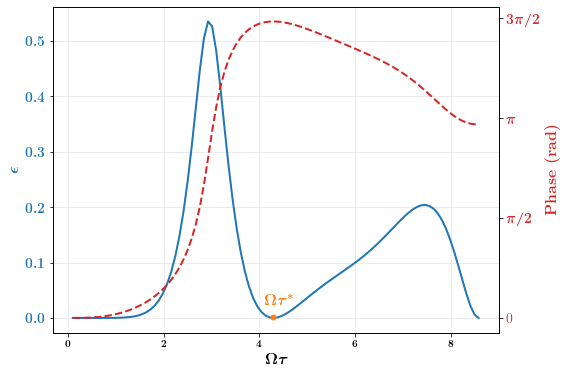

In [366]:
# Plot

fig, ax1 = plt.subplots(1,1, figsize=(8,6))

ax2 = ax1.twinx() 

i1 = 0
i2 = 3

ax2.plot(prod_Ot_list, phase_in_radians, color=col[i2], ls='--', lw='2', yunits=radians) 
ax1.plot(prod_Ot_list, err_list, color=col[i1], ls='-', lw='2', yunits=radians)  

ax1.plot(4.29268,0.001,'.', marker=".", markersize=10, color=col[1])
ax1.text(4.1,0.025,r'$\Omega\tau^*$',fontsize=16,color=col[1])

ax1.set_xlabel(r'$\Omega \tau$', fontsize=16);

ax1.set_ylabel(r'$\epsilon$', fontsize=16, color=col[i1])
ax1.tick_params(axis='y', labelcolor=col[i1], labelsize=14)

ax2.set_ylabel(r'\bf{Phase (rad)}', fontsize=16, color=col[i2])
ax2.tick_params(axis='y', labelcolor=col[i2], labelsize=14)

ax1.grid(color='0.9')

plt.savefig("plots/epsilon-phase_omega-tau.pdf", bbox_inches='tight')
plt.show()

### Figure of merit as a function of $\Delta/\Omega$ (N=2 qubit)

In [186]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega
tau = prod_Ot / Omega

# State initialization
N = 2 # number of qubits
state_first = 1
state_last = 1
psi_init = chain_init(N,state_first,state_last)

# State evolution
frac_DO_list = np.linspace(0,1.7,50)

err_list = []
phase_list = []

for ff in frac_DO_list:
    
    Delta = ff * Omega 
    psi_res = chain_CZ_gate(psi_init,Omega,Delta,tau,50)
    err_list.append( 1-fidelity(psi_res,psi_init) )
    number = np.conj(psi_res[4][0][0])
    phase_list.append( phase_func( number ) )
    
phase_in_radians = [val*radians for val in phase_list]

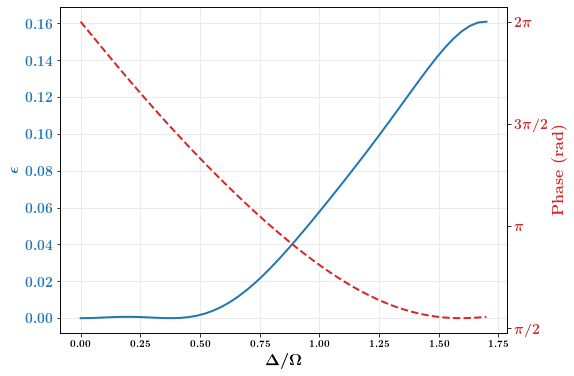

In [187]:
# Plot

fig, ax1 = plt.subplots(1,1, figsize=(8,6))

ax2 = ax1.twinx()

i1 = 0
i2 = 3

ax2.plot(frac_DO_list, np.array(phase_in_radians), color=col[i2], ls='--', lw='2', yunits=radians) 
ax1.plot(frac_DO_list, np.array(err_list), color=col[i1], ls='-', lw='2', yunits=radians)  

#ax1.plot(0.377,0.0005,'.', marker=".", markersize=10, color=col[1])
#ax1.text(0.36,0.01,r'$\frac{\Delta}{\Omega}^*$',fontsize=16,color=col[1])

ax1.set_xlabel(r'$\Delta/\Omega$', fontsize=16);

ax1.set_ylabel(r'$\epsilon$', fontsize=16, color=col[i1])
ax1.tick_params(axis='y', labelcolor=col[i1], labelsize=14)

ax2.set_ylabel(r'\bf{Phase (rad)}', fontsize=16, color=col[i2])
ax2.tick_params(axis='y', labelcolor=col[i2], labelsize=14)

ax1.grid(color='0.9')

plt.savefig("plots/epsilon-phase_delta-omega.pdf", bbox_inches='tight')
plt.show()

### Gaussian error on  $\tau$ propagated through the N-qubit chain

In [102]:
def chain_CZ_gate_error_tau(psi,Omega,Delta,tau,niter,sigma):
        
    N = len(dims(psi)[0]) # Number of qubits in the chain
    I = qeye(3) # Define identity matrix
    
    tau_star = tau
    
    for i in range(N-1):
        
        tau1 = tau_star + np.random.normal(0,sigma) 
        times1 = np.linspace(0.0, tau1, niter)
        
        tau2 = tau_star + np.random.normal(0,sigma) 
        times2 = np.linspace(0.0, tau2, niter)
        
        if i==0:
            H1 = Qobj( hamiltonian(Omega,Delta), dims= [[3, 3, 3], [3, 3, 3]] )
            H2 = Qobj( hamiltonian(Omega * exp_xi(Delta,Omega,tau2), Delta) , dims= [[3, 3, 3], [3, 3, 3]] )
        else:
            H1 = I
            H2 = I
        
        for j in range(N-2):
        
            if j==(i-1):
        
                Hp1 = Qobj( hamiltonian(Omega,Delta), dims= [[3, 3, 3], [3, 3, 3]] )
                Hp2 = Qobj( hamiltonian(Omega * exp_xi(Delta,Omega,tau2), Delta) , dims= [[3, 3, 3], [3, 3, 3]] )
                
                H1 = tensor(H1,Hp1)                
                H2 = tensor(H2,Hp2)
            else:
                H1 = tensor(H1,I)
                H2 = tensor(H2,I)
        
        result = mesolve(H1, psi, times1,[], [])
        psi = result.states[-1]
        

        result = mesolve(H2, psi, times2,[], [])
        psi = result.states[-1]
    
    return psi

In [12]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega
tau = prod_Ot / Omega

N = 3 # number of qubits
state_first = 1
state_last = 1
psi_init = chain_init(N,state_first,state_last)

psi_res = chain_CZ_gate_error_tau(psi_init,Omega,Delta,tau,50,0)

#print(psi_res)

In [ ]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega
tau = prod_Ot / Omega

sigma_list = np.linspace(0.01,0.1,10)

ntimes = 100
niter = 20
N_qubits = [5]

for nq in N_qubits:
    
    filename = 'err_tau_'+str(nq)+'.txt'
    psi_init = chain_init(nq,1,1)
    
    if os.path.exists(filename): 
        os.remove(filename)

    for ss in range(len(sigma_list)):
        
        print(nq,ss)
        
        err = []
        
        for nn in range(ntimes):
            
            psi_fin = chain_CZ_gate_error_tau(psi_init,Omega,Delta,tau,niter,sigma_list[ss]*tau)
            
            err.append(1-fidelity(psi_fin,psi_init))
            
        mean = np.mean(err)
        std = np.std(err)/np.sqrt(ntimes)
            
        with open(filename, "a") as f:
            writer = csv.writer(f)
            writer.writerow((sigma_list[ss], mean, std))

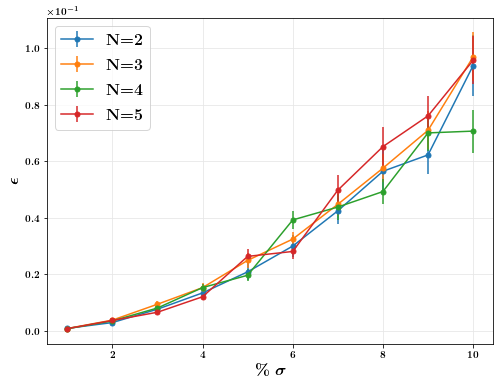

In [238]:
head = ["sigma","epsilon","err"]

df2 = pd.read_csv('./results/err_tau_2.txt', header=None, names=head)
df3 = pd.read_csv('./results/err_tau_3.txt', header=None, names=head)
df4 = pd.read_csv('./results/err_tau_4.txt', header=None, names=head)
df5 = pd.read_csv('./results/err_tau_5.txt', header=None, names=head)

# Plot
fig, ax1 = plt.subplots(1,1, figsize=(8,6))

i2 = 0
i3 = 1
i4 = 2
i5 = 3

ax1.errorbar(df2['sigma']*100, df2['diff'], yerr=df2['err'], fmt='-o', markerfacecolor=col[i2], 
            color=col[i2], ecolor=col[i2],label=r'\bf{N=2}',alpha=1,markersize=5)

ax1.errorbar(df3['sigma']*100, df3['epsilon'], yerr=df3['err'], fmt='-o', markerfacecolor=col[i3], 
            color=col[i3], ecolor=col[i3],label=r'\bf{N=3}',alpha=1,markersize=5)

ax1.errorbar(df4['sigma']*100, df4['epsilon'], yerr=df4['err'], fmt='-o', markerfacecolor=col[i4], 
            color=col[i4], ecolor=col[i4],label=r'\bf{N=4}',alpha=1,markersize=5)

ax1.errorbar(df5['sigma']*100, df5['epsilon'], yerr=df5['err'], fmt='-o', markerfacecolor=col[i5], 
            color=col[i5], ecolor=col[i5],label=r'\bf{N=5}',alpha=1,markersize=5)

ax1.set_xlabel(r'$\%$ $\sigma$ ', fontsize=16);
ax1.set_ylabel(r'$\epsilon$', fontsize=16)
ax1.grid(color='0.9')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(loc='upper left',fontsize=16)
plt.savefig("plots/chain_sigma_tau.pdf", bbox_inches='tight')

### Gaussian error on  $\Delta/\Omega$ propagated through the N-qubit chain

In [115]:
def chain_CZ_gate_error_delta(psi,Omega,Delta,tau,niter,sigma):
        
    N = len(dims(psi)[0]) # Number of qubits in the chain
    I = qeye(3) # Define identity matrix
    times = np.linspace(0.0, tau, niter)
    
    Delta_star = Delta
    
    for i in range(N-1):
        
        Delta1 = Delta_star + np.random.normal(0,sigma) 
        Delta2 = Delta_star + np.random.normal(0,sigma) 
        
        if i==0:
            H1 = Qobj( hamiltonian(Omega,Delta1), dims= [[3, 3, 3], [3, 3, 3]] )
            H2 = Qobj( hamiltonian(Omega * exp_xi(Delta2,Omega,tau), Delta2) , dims= [[3, 3, 3], [3, 3, 3]] )
        else:
            H1 = I
            H2 = I
        
        for j in range(N-2):
        
            if j==(i-1):
        
                Hp1 = Qobj( hamiltonian(Omega,Delta1), dims= [[3, 3, 3], [3, 3, 3]] )
                Hp2 = Qobj( hamiltonian(Omega * exp_xi(Delta2,Omega,tau), Delta2) , dims= [[3, 3, 3], [3, 3, 3]] )
                
                H1 = tensor(H1,Hp1)                
                H2 = tensor(H2,Hp2)
            else:
                H1 = tensor(H1,I)
                H2 = tensor(H2,I)
        
        result = mesolve(H1, psi, times,[], [])
        psi = result.states[-1]
        
        result = mesolve(H2, psi, times,[], [])
        psi = result.states[-1]
    
    return psi

#### $\epsilon$

In [128]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega
tau = prod_Ot / Omega

sigma_list = np.linspace(0.01,0.1,10)

ntimes = 100
niter = 20
N_qubits = [5]

for nq in N_qubits:
    
    filename = 'err_delta_'+str(nq)+'.txt'
    psi_init = chain_init(nq,1,1)
    
    if os.path.exists(filename): 
        os.remove(filename)

    for ss in range(len(sigma_list)):
        
        print(nq,ss)
        
        err = []
        
        for nn in range(ntimes):
            
            psi_fin = chain_CZ_gate_error_delta(psi_init,Omega,Delta,tau,niter,sigma_list[ss]*Delta)
            
            err.append(1-fidelity(psi_fin,psi_init))
            
        mean = np.mean(err)
        std = np.std(err)/np.sqrt(ntimes)
            
        with open(filename, "a") as f:
            writer = csv.writer(f)
            writer.writerow((sigma_list[ss], mean, std))

5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9


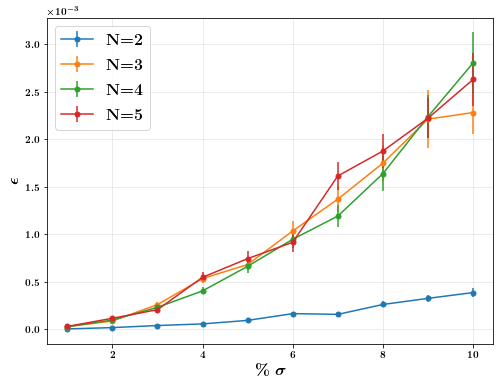

In [237]:
head = ["sigma","epsilon","err"]

df2 = pd.read_csv('./results/err_delta_2.txt', header=None, names=head)
df3 = pd.read_csv('./results/err_delta_3.txt', header=None, names=head)
df4 = pd.read_csv('./results/err_delta_4.txt', header=None, names=head)
df5 = pd.read_csv('./results/err_delta_5.txt', header=None, names=head)

# Plot
fig, ax1 = plt.subplots(1,1, figsize=(8,6))

i2 = 0
i3 = 1
i4 = 2
i5 = 3

ax1.errorbar(df2['sigma']*100, df2['epsilon'], yerr=df2['err'], fmt='-o', markerfacecolor=col[i2], 
            color=col[i2], ecolor=col[i2],label=r'\bf{N=2}',alpha=1,markersize=5)

ax1.errorbar(df3['sigma']*100, df3['epsilon'], yerr=df3['err'], fmt='-o', markerfacecolor=col[i3], 
            color=col[i3], ecolor=col[i3],label=r'\bf{N=3}',alpha=1,markersize=5)

ax1.errorbar(df4['sigma']*100, df4['epsilon'], yerr=df4['err'], fmt='-o', markerfacecolor=col[i4], 
            color=col[i4], ecolor=col[i4],label=r'\bf{N=4}',alpha=1,markersize=5)

ax1.errorbar(df5['sigma']*100, df5['epsilon'], yerr=df5['err'], fmt='-o', markerfacecolor=col[i5], 
            color=col[i5], ecolor=col[i5],label=r'\bf{N=5}',alpha=1,markersize=5)

ax1.set_xlabel(r'$\%$ $\sigma$', fontsize=16);
ax1.set_ylabel(r'$\epsilon$', fontsize=16)
ax1.grid(color='0.9')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(loc='upper left',fontsize=16)
plt.savefig("plots/chain_sigma_delta.pdf", bbox_inches='tight')

#### phase

In [353]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega
tau = prod_Ot / Omega

ntimes = 1
niter = 20

N = 3
sigma = 0.0

psi_init = chain_init(N,1,1)
psi_fin = chain_CZ_gate_error_delta(psi_init,Omega,Delta,tau,niter,sigma*Delta)
psi_fin_11 = psi_fin 

phase_11 = phase_func( np.conj(psi_fin[int(3**(N-1)+1)][0][0]) )

psi_init = chain_init(N,0,1)
psi_fin = chain_CZ_gate_error_delta(psi_init,Omega,Delta,tau,niter,sigma*Delta)

phase_01 = phase_func( np.conj(psi_fin[1][0][0]) ) 

print('01',phase_01)
print('11',phase_11)
print('diff:',  2 * phase_01 - np.pi - phase_11 )

print('psi11:',psi_fin_11[int(3**(N-1)+1)][0][0])

01 3.9024299052023785
11 1.5216745032226964
diff: 3.1415926535922676
psi11: (0.04910207116825363-0.9987937656519829j)


In [356]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega
tau = prod_Ot / Omega

sigma_list = np.linspace(0.0,0.1,11)

ntimes = 100
niter = 20
N_qubits = [5]

for nq in N_qubits:
    
    filename = 'phase_delta_'+str(nq)+'.txt'
    psi_init_01 = chain_init(nq,0,1)
    psi_init_11 = chain_init(nq,1,1)
    
    if os.path.exists(filename): 
        os.remove(filename)

    for ss in range(len(sigma_list)):
        
        print(nq,ss)
        
        phase_01 = []
        phase_11 = []
        
        for nn in range(ntimes):
            
            psi_fin_01 = chain_CZ_gate_error_delta(psi_init_01,Omega,Delta,tau,niter,sigma_list[ss]*Delta)
            psi_fin_11 = chain_CZ_gate_error_delta(psi_init_11,Omega,Delta,tau,niter,sigma_list[ss]*Delta)

            number_01 = np.conj(psi_fin_01[1][0][0])
            number_11 = np.conj(psi_fin_11[int(3**(nq-1)+1)][0][0])      
            
            phase_01.append( phase_func( number_01 ) )
            phase_11.append( phase_func( number_11 ) )
          
        
        mean_01 = np.mean(phase_01)
        std_01 = np.std(phase_01)/np.sqrt(ntimes)

        mean_11 = np.mean(phase_11)
        std_11 = np.std(phase_11)/np.sqrt(ntimes)
        
        diff = 2*mean_01 - np.pi - mean_11
        std_diff = np.sqrt(std_11**2+std_01**2)
        
        with open(filename, "a") as f:
            writer = csv.writer(f)
            writer.writerow((sigma_list[ss], diff, std_diff))

5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10


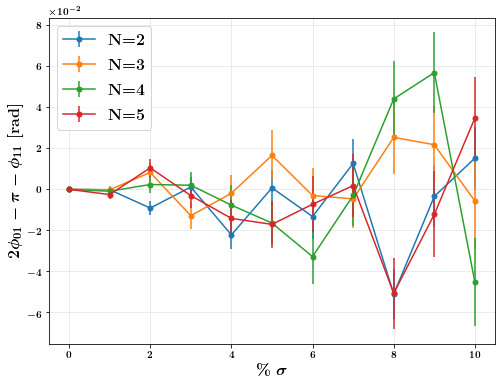

In [361]:
head = ["sigma","diff","err"]

df2 = pd.read_csv('./results/phase_delta_2.txt', header=None, names=head)
df3 = pd.read_csv('./results/phase_delta_3.txt', header=None, names=head)
df4 = pd.read_csv('./results/phase_delta_4.txt', header=None, names=head)
df5 = pd.read_csv('./results/phase_delta_5.txt', header=None, names=head)

# Plot
fig, ax1 = plt.subplots(1,1, figsize=(8,6))

i2 = 0
i3 = 1
i4 = 2
i5 = 3

ax1.errorbar(df2['sigma']*100, df2['diff'], yerr=df2['err'], fmt='-o', markerfacecolor=col[i2],
             color=col[i2], ecolor=col[i2],label=r'\bf{N=2}',alpha=1,markersize=5)

ax1.errorbar(df3['sigma']*100, df3['diff']-np.pi, yerr=df3['err'], fmt='-o', markerfacecolor=col[i3], 
            color=col[i3], ecolor=col[i3],label=r'\bf{N=3}',alpha=1,markersize=5)

ax1.errorbar(df4['sigma']*100, df4['diff']-np.pi, yerr=df4['err'], fmt='-o', markerfacecolor=col[i4], 
            color=col[i4], ecolor=col[i4],label=r'\bf{N=4}',alpha=1,markersize=5)

ax1.errorbar(df5['sigma']*100, df5['diff']-np.pi, yerr=df5['err'], fmt='-o', markerfacecolor=col[i5], 
            color=col[i5], ecolor=col[i5],label=r'\bf{N=5}',alpha=1,markersize=5)

ax1.set_xlabel(r'$\%$ $\sigma$', fontsize=16);
ax1.set_ylabel(r'$ 2\phi_{01} - \pi - \phi_{11}$  \bf{[rad]}', fontsize=16)
ax1.grid(color='0.9')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(loc='upper left',fontsize=16)
plt.savefig("plots/chain_phase_sigma_delta.pdf", bbox_inches='tight')

### Measurement of a two-qubit system with noise on $\tau$ and $\Delta$

In [18]:
# Function to find probability of configurations
def prepareMeasurement(N, psi):
    
    confs = list(itertools.product([0, 1, 2], repeat=N))
    P = []
    
    for conf in confs:
        psi_ref = tensor([basis(3, m) for m in conf])
        p = np.abs(psi.overlap(psi_ref))**2.
        P.append(p)
    return confs, np.array(P)

# Function to simulate measurement process
def simulateMeasurement(confs, P, n):
    return np.random.choice(range(len(confs)), n, p=P)

In [188]:
# Fix parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268

# State initialization
N = 2 # number of qubits
state_first = 1
state_last = 1
psi_init = chain_init(N,state_first,state_last)

# Run several times with gaussian noise on parameters
niter = 30
sigma = 0.01
n_trials = 1000 
psi_list = []

for nn in range(n_trials):
    
    Delta = frac_DO + np.random.normal(0.,sigma*frac_DO)
    tau = prod_Ot + np.random.normal(0.,sigma*prod_Ot)

    psi_fin = chain_CZ_gate(psi_init,Omega,Delta,tau,niter)
    psi_list.append(psi_fin)


In [189]:
meas_list = []

n_meas = 10000

for psi in psi_list:
    confs, P = prepareMeasurement(N, psi)
    meas = list( simulateMeasurement(confs, P, n_meas) )
    meas_list = meas_list + meas 
    
unique, counts = np.unique(meas_list, return_counts=True)

unique = list(unique) + [8]
counts = list(counts) + [0]

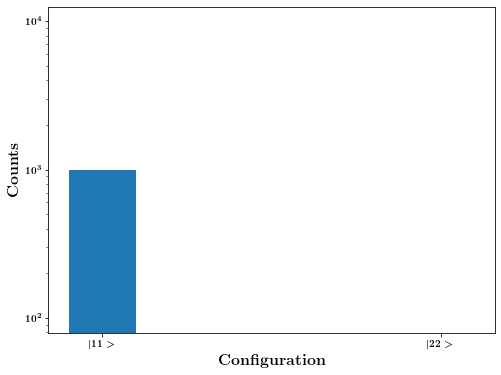

In [191]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.bar([0,1,2,3], height=counts,color=col[0])
labels = [r"$\ket{11}$",r"$\ket{1r}$",r"$\ket{r1}$",r"$\ket{rr}$"]
plt.xticks([0,1,2,3], labels)
ax.set_ylim(10**3,10**(7.5))

# USEFUL
#base = [np.base_repr(n, base=3) for n in unique]
#ax.bar(unique, height=counts,color=col[0])
#plt.xticks(unique, [r"$|{0}>$".format(m) for m in base])

ax.set_xlabel(r'\bf{Configuration}',fontsize=16)
ax.set_ylabel(r'\bf{Counts}',fontsize=16)
ax.set_yscale('log')
plt.savefig("plots/noise_measurement_two-qubit.pdf", bbox_inches='tight')
plt.show()

## Imperfect blockade

### Functions definition

In [34]:
# Definition of the Hamiltonian for imperfect blockade regime
def hamiltonian_imperfect(Omega,Delta,V):
    
    psi00 = basis(9,0)
    psi01 = basis(9,1) 
    psi0r = basis(9,2)
    psi10 = basis(9,3)
    psi11 = basis(9,4) 
    psi1r = basis(9,5)
    psir0 = basis(9,6)
    psir1 = basis(9,7)
    psirr = basis(9,8)

    H0  = 0 * tensor(psi00.dag(),psi00)
    
    H01 = 1/2 * ( Omega * tensor(psi01.dag(),psi0r) + 
             np.conj(Omega) * tensor(psi0r.dag(),psi01) ) - Delta * tensor(psi0r.dag(),psi0r)
    
    H10 = 1/2 * ( Omega * tensor(psi10.dag(),psir0) + 
             np.conj(Omega) * tensor(psir0.dag(),psi10) ) - Delta * tensor(psir0.dag(),psir0)

    H2  = np.sqrt(2)/2 * ( Omega * ( tensor(psi11.dag(),psir1) + tensor(psi11.dag(),psi1r) + 
                                    tensor(psi1r.dag(),psirr) + tensor(psir1.dag(),psirr) ) 
            + np.conj(Omega) * ( tensor(psir1.dag(),psi11) + tensor(psi1r.dag(),psi11) + 
                                tensor(psirr.dag(),psi1r) + tensor(psirr.dag(),psir1) ) 
            ) - Delta * ( tensor(psir1.dag(),psir1) + tensor(psir1.dag(),psi1r) 
                           + tensor(psi1r.dag(),psir1) + tensor(psi1r.dag(),psi1r)) + (V-2*Delta) * (tensor(psirr.dag(),psirr))

    H = H0 + H01 + H10 + H2
    
    return H

# Optimal phase between two pulse
def exp_xi(Delta,Omega,tau):
    
    y = Delta/Omega
    s = Omega * tau
    
    a = np.sqrt(y**2+1)
    b = s*a/2
    
    return (a*np.cos(b) + 1j*y*np.sin(b)) / (-a*np.cos(b) + 1j*y*np.sin(b))

In [35]:
# Implementation of two-qubit CZ gate
def CZ_gate_imperfect(psi,Omega,Delta,tau,V):
        
    # Times discretization
    times = np.linspace(0.0, tau, 200)
    
    # Apply first pulse (unitary evolution with Lindblad Master Equation Solver)
    H = hamiltonian_imperfect(Omega,Delta,V)
    result = mesolve(H, psi, times,[], [])
    psi = result.states[-1]
    
    # Apply second pulse rotated by Omega -> Omega exp(i xi)
    H = hamiltonian_imperfect(Omega * exp_xi(Delta,Omega,tau), Delta, V)
    result = mesolve(H, psi, times,[], [])
    psi = result.states[-1] 
        
    return psi


# System evolution under a single unitary pulse
def evol_CZ_gate_imperfect(psi,Omega,Delta,tau,V,rho_ref):
        
    # Times discretization
    times = np.linspace(0.0, 3*tau, 200)
    
    # Apply first pulse
    H = hamiltonian_imperfect(Omega,Delta,V)
    result = mesolve(H, psi, times,[], [rho_ref])
        
    return result

# Chain state initialization
def CZ_init(state_first,state_last):
    
    psi = basis(3,state_first) 
    psi = tensor(psi,basis(3,state_last))
    
    return psi

### Measurement of a two-qubit system with noise on $\tau$ and $\Delta$

#### V $\sim$ 1

In [231]:
state_first = 1
state_last = 1
psi_init = CZ_init(state_first,state_last)

V = 1
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega
tau = prod_Ot * Omega

psi_fin = CZ_gate_imperfect(psi_init,Omega,Delta,tau,V)

#fidelity(psi_fin,psi_init)
psi_fin

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.7198569 -0.21049874j]
 [ 0.09750238+0.1460271j ]
 [ 0.        +0.j        ]
 [ 0.09750238+0.1460271j ]
 [-0.05563585+0.61052414j]]

In [228]:
# Fix parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
V = 1

# State initialization
state_first = 1
state_last = 1
psi_init = CZ_init(state_first,state_last)

# Run several times with gaussian noise on parameters
n_trials = 1000
sigma = 0.01
psi_list = []

for nn in range(n_trials):
    
    Delta = frac_DO + np.random.normal(0.,sigma*frac_DO)
    tau = prod_Ot + np.random.normal(0.,sigma*prod_Ot)

    psi_fin = CZ_gate_imperfect(psi_init,Omega,Delta,tau,V)
    psi_list.append(psi_fin)

In [229]:
meas_list = []

n_meas = 10000

for psi in psi_list:
    confs, P = prepareMeasurement(N, psi)
    meas = list( simulateMeasurement(confs, P, n_meas) )
    meas_list = meas_list + meas 
    
unique, counts = np.unique(meas_list, return_counts=True)

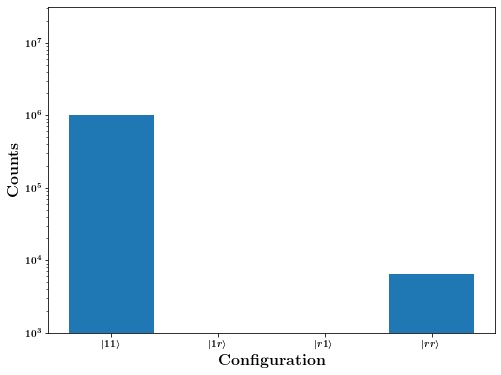

In [230]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.bar([0,1,2,3], height=counts,color=col[0])
labels = [r"$\ket{11}$",r"$\ket{1r}$",r"$\ket{r1}$",r"$\ket{rr}$"]
plt.xticks([0,1,2,3], labels)
ax.set_ylim(10**3,10**(7.5))

ax.set_xlabel(r'\bf{Configuration}',fontsize=16)
ax.set_ylabel(r'\bf{Counts}',fontsize=16)
ax.set_yscale('log')

plt.savefig("plots/noise_measurement_two-qubit_imp_Vlow.pdf", bbox_inches='tight')
plt.show()

#### V >> 1

In [75]:
# Fix parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
V = 100

# State initialization
state_first = 1
state_last = 1
psi_init = CZ_init(state_first,state_last)

# Run several times with gaussian noise on parameters
n_trials = 1000
sigma = 0.01 #0.001
psi_list = []

for nn in range(n_trials):
    
    Delta = frac_DO * (Omega**2/(2*V)) + np.random.normal(0.,sigma*frac_DO)  # DA RIVEDERE!!!!
    tau = prod_Ot + np.random.normal(0.,sigma*prod_Ot)

    psi_fin = CZ_gate_imperfect(psi_init,Omega,Delta,tau,V)
    psi_list.append(psi_fin)

In [48]:
psi_fin

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j]
 [9.99992134e-01+3.54121432e-03j]
 [5.06311618e-04+1.83528959e-06j]
 [0.00000000e+00+0.00000000e+00j]
 [5.06311618e-04+1.83528959e-06j]
 [1.18366477e-03+1.13030980e-03j]]

In [76]:
meas_list = []

n_meas = 10000

for psi in psi_list:
    confs, P = prepareMeasurement(N, psi)
    meas = list( simulateMeasurement(confs, P, n_meas) )
    meas_list = meas_list + meas 
    
unique, counts = np.unique(meas_list, return_counts=True)

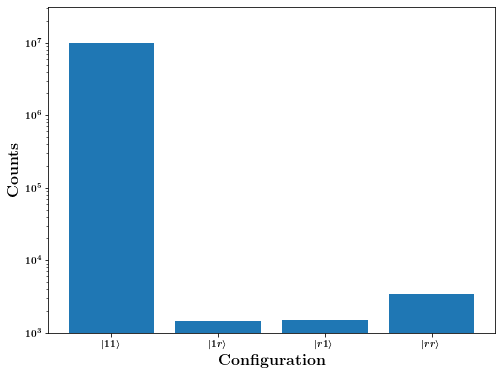

In [94]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

#ax.bar(unique, height=counts,color=col[0])
#base = [np.base_repr(n, base=3) for n in unique]
#plt.xticks(unique, [r"$|{0}>$".format(m) for m in base])

ax.bar([0,1,2,3], height=counts,color=col[0])
#labels = [r"$|11>$",r"$|1r>$",r"$|r1>$",r"$|rr>$"]
labels = [r"$\ket{11}$",r"$\ket{1r}$",r"$\ket{r1}$",r"$\ket{rr}$"]
plt.xticks([0,1,2,3], labels)
ax.set_ylim(10**3,10**(7.5))

ax.set_xlabel(r'\bf{Configuration}',fontsize=16)
ax.set_ylabel(r'\bf{Counts}',fontsize=16)
ax.set_yscale('log')
plt.savefig("plots/noise_measurement_two-qubit_imp_Vbig.pdf", bbox_inches='tight')
plt.show()